# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [1]:
# import wget
# wget.download("https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py")

In [2]:
# Setup imports
import tensorflow as tf
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [3]:
# import wget
# wget.download("https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip")
# unzip_data("101_food_classes_10_percent.zip")

In [4]:
# Setup train and test directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [6]:
# Setup data inputs
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)  # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes training data

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint/checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# Create data augmentation layer to incorporate it right into the model
# IMG_SHAPE = IMG_SIZE + (3,)

data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.Input(shape=IMG_SHAPE),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    # tf.keras.layers.Rescaling(1./255),  # Keep for models like ResNet50V2 but EfficientNet's having rescale built-in
], name="data_augmentation")

In [9]:
# Setup the base model and freeze its layers (this will extract features)
IMG_SHAPE = IMG_SIZE + (3,)
input_shape = IMG_SHAPE
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)  # Augment images (only happens during training phase)
x = base_model(x, training=False)  # Put the base model in inference mode so weights which need to stay frozen, stay frozen
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names),
                                    activation="softmax",
                                    name="output_layer")(x)

# Make a model using the inputs and outputs
model = tf.keras.Model(inputs, outputs)

In [10]:
# Get a summary of the model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [12]:
# Feature extract for 5 full passes and validate on 15% of the test data, to save epoch time
INITIAL_EPOCHS = 5

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=INITIAL_EPOCHS,
                                           steps_per_epoch=len(train_data_all_10_percent),
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 53s 196ms/step - loss: 3.3732 - accuracy: 0.2676 - val_loss: 2.6138 - val_accuracy: 0.4158
Epoch 2/5
237/237 [==============================] - 36s 150ms/step - loss: 2.2027 - accuracy: 0.4982 - val_loss: 2.0894 - val_accuracy: 0.5024
Epoch 3/5
237/237 [==============================] - 33s 139ms/step - loss: 1.8221 - accuracy: 0.5649 - val_loss: 1.9381 - val_accuracy: 0.5143
Epoch 4/5
237/237 [==============================] - 30s 128ms/step - loss: 1.6063 - accuracy: 0.6086 - val_loss: 1.8420 - val_accuracy: 0.5225
Epoch 5/5
237/237 [==============================] - 28s 117ms/step - loss: 1.4507 - accuracy: 0.6437 - val_loss: 1.8247 - val_accuracy: 0.5267


In [13]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 30s 38ms/step - loss: 1.5800 - accuracy: 0.5865


[1.5800271034240723, 0.5865346789360046]

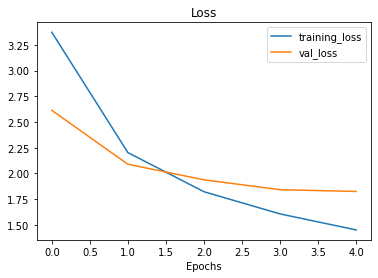

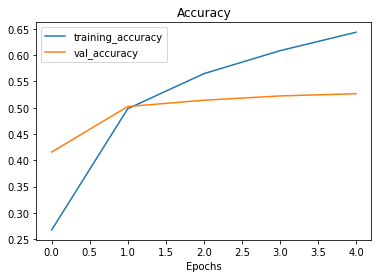

In [14]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 ❓ **Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine-tuning

In [15]:
# To begin fine-tuning, let's sunfreeze the last 5 layers of our base_model
for layer in base_model.layers[-5:]:
    layer.trainable = True

In [16]:
# Recompile the model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # learning rate lowered by 10x
              metrics=["accuracy"])

In [17]:
# What layers are trainable?
for layer_number, layer in enumerate(model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 False
3 global_average_pooling_layer True
4 output_layer True


In [18]:
# Check which layers are trainable in our base_model
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [19]:
# Fine-tune for 5 more epochs
fine_tune_epochs = INITIAL_EPOCHS + 5
# fine_tune_epochs = 10  # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 31s 118ms/step - loss: 1.2883 - accuracy: 0.6888 - val_loss: 1.7737 - val_accuracy: 0.5384
Epoch 6/10
237/237 [==============================] - 26s 108ms/step - loss: 1.2674 - accuracy: 0.6999 - val_loss: 1.7550 - val_accuracy: 0.5440
Epoch 7/10
237/237 [==============================] - 25s 105ms/step - loss: 1.2513 - accuracy: 0.7027 - val_loss: 1.7487 - val_accuracy: 0.5461
Epoch 8/10
237/237 [==============================] - 24s 102ms/step - loss: 1.2435 - accuracy: 0.7042 - val_loss: 1.7488 - val_accuracy: 0.5453
Epoch 9/10
237/237 [==============================] - 23s 96ms/step - loss: 1.2262 - accuracy: 0.7072 - val_loss: 1.7387 - val_accuracy: 0.5477
Epoch 10/10
237/237 [==============================] - 23s 95ms/step - loss: 1.2223 - accuracy: 0.7142 - val_loss: 1.7476 - val_accuracy: 0.5450


In [20]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 31s 39ms/step - loss: 1.5379 - accuracy: 0.5955


[1.5379085540771484, 0.5954851508140564]

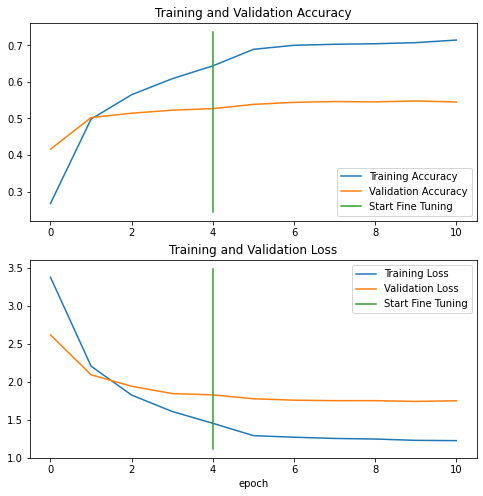

In [21]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [22]:
# Save our fine-tuning model
model.save("tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: tensorflow_course/101_food_classes_10_percent_saved_big_dog_model\assets


INFO:tensorflow:Assets written to: tensorflow_course/101_food_classes_10_percent_saved_big_dog_model\assets


In [23]:
# Load an evaluated saved model
loaded_model = tf.keras.models.load_model("tensorflow_course/101_food_classes_10_percent_saved_big_dog_model/")

In [24]:
# Evaluate loaded model and compare to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 52s 64ms/step - loss: 1.5379 - accuracy: 0.5956


[1.5379090309143066, 0.5956039428710938]

In [25]:
# The results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.5379085540771484, 0.5954851508140564]

## Evaluating the performance of the big dog model across all the different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [26]:
# Download pretrained model (one that was prepared earlier, so all predictions are similar)
# import wget
# wget.download("https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [27]:
# unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

> 🔑 **Note:** Loading the model with the following call will output a large amount of warnings, there is a thread tracking this issue on GitHub: https://github.com/tensorflow/tensorflow/issues/40166, however, it seems according to TensorFlow documentation, loading warnings can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_usage

In [28]:
# Load in saved model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [29]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 51s 63ms/step - loss: 1.8021 - accuracy: 0.6078


[1.8021461963653564, 0.6078416109085083]

## Making predictions with our trained model

In [30]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1)  # set verbosity to see how long is left

790/790 [==============================] - 48s 61ms/step


In [31]:
# How many predictions are there?
len(preds_probs)

25250

In [32]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [33]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9249271e-02, 3.5662767e-06, 4.1342977e-02, ..., 1.4138000e-09,
        8.3919571e-05, 3.0702592e-03],
       [9.6344250e-01, 1.3782779e-09, 8.5211132e-04, ..., 5.4725304e-05,
        7.8252665e-12, 9.8093478e-10],
       [9.5949811e-01, 3.2507120e-05, 1.4778678e-03, ..., 7.1361859e-07,
        5.4917035e-07, 4.0147519e-05],
       ...,
       [4.7357541e-01, 1.2904141e-07, 1.4718862e-03, ..., 5.9495331e-04,
        6.7357629e-05, 2.3440351e-05],
       [4.4577826e-02, 4.7394090e-07, 1.2250699e-01, ..., 6.3264847e-06,
        7.5687212e-06, 3.6870509e-03],
       [7.2434467e-01, 1.9301443e-09, 5.2372430e-05, ..., 1.2222704e-03,
        1.5801617e-09, 9.6437310e-05]], dtype=float32)

In [34]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.92492707e-02, 3.56627675e-06, 4.13429774e-02, 1.05817655e-09,
        8.16343260e-09, 8.59343974e-09, 8.10488871e-07, 8.39763288e-07,
        1.97921690e-05, 7.95607377e-07, 3.17159277e-09, 9.77406785e-07,
        2.83403904e-04, 7.71722297e-10, 7.40544579e-04, 3.86414358e-05,
        6.43682461e-06, 2.48607512e-06, 3.76129901e-05, 2.04468051e-07,
        1.54993577e-05, 8.07823483e-07, 2.60986576e-06, 2.03207989e-07,
        8.29707460e-07, 5.40059818e-06, 3.73345028e-06, 1.31608902e-08,
        2.74173380e-03, 2.78202788e-05, 6.80790591e-10, 2.52925129e-05,
        1.66082653e-04, 7.55078666e-10, 4.00453544e-04, 1.30613600e-08,
        1.78422283e-06, 1.43750503e-06, 2.30568536e-02, 8.23618166e-07,
        8.61664034e-07, 1.68742952e-06, 7.04464810e-06, 1.84932194e-08,
        2.86604148e-07, 7.98858764e-06, 2.07005451e-06, 1.85816234e-07,
        3.32930341e-08, 3.16543796e-04, 1.04754945e-05, 8.56006011e-07,
        8.47906530e-01, 1.05081144e-05, 4.35925244e-07, 3.714325

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [35]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.92492707e-02 3.56627675e-06 4.13429774e-02 1.05817655e-09
 8.16343260e-09 8.59343974e-09 8.10488871e-07 8.39763288e-07
 1.97921690e-05 7.95607377e-07 3.17159277e-09 9.77406785e-07
 2.83403904e-04 7.71722297e-10 7.40544579e-04 3.86414358e-05
 6.43682461e-06 2.48607512e-06 3.76129901e-05 2.04468051e-07
 1.54993577e-05 8.07823483e-07 2.60986576e-06 2.03207989e-07
 8.29707460e-07 5.40059818e-06 3.73345028e-06 1.31608902e-08
 2.74173380e-03 2.78202788e-05 6.80790591e-10 2.52925129e-05
 1.66082653e-04 7.55078666e-10 4.00453544e-04 1.30613600e-08
 1.78422283e-06 1.43750503e-06 2.30568536e-02 8.23618166e-07
 8.61664034e-07 1.68742952e-06 7.04464810e-06 1.84932194e-08
 2.86604148e-07 7.98858764e-06 2.07005451e-06 1.85816234e-07
 3.32930341e-08 3.16543796e-04 1.04754945e-05 8.56006011e-07
 8.47906530e-01 1.05081144e-05 4.35925244e-07 3.71432507e-05
 3.49659385e-05 3.23969143e-05 6.69934743e-

In [36]:
test_data.class_names[52]

'gyoza'

In [37]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0], dtype=int64)

In [38]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [39]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())  # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10]  # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [40]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [41]:
results_downloaded_model

[1.8021461963653564, 0.6078416109085083]

In [42]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

0.6078415841584158

In [43]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [44]:
# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ### Changed (plot x-labels vertically) ###
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

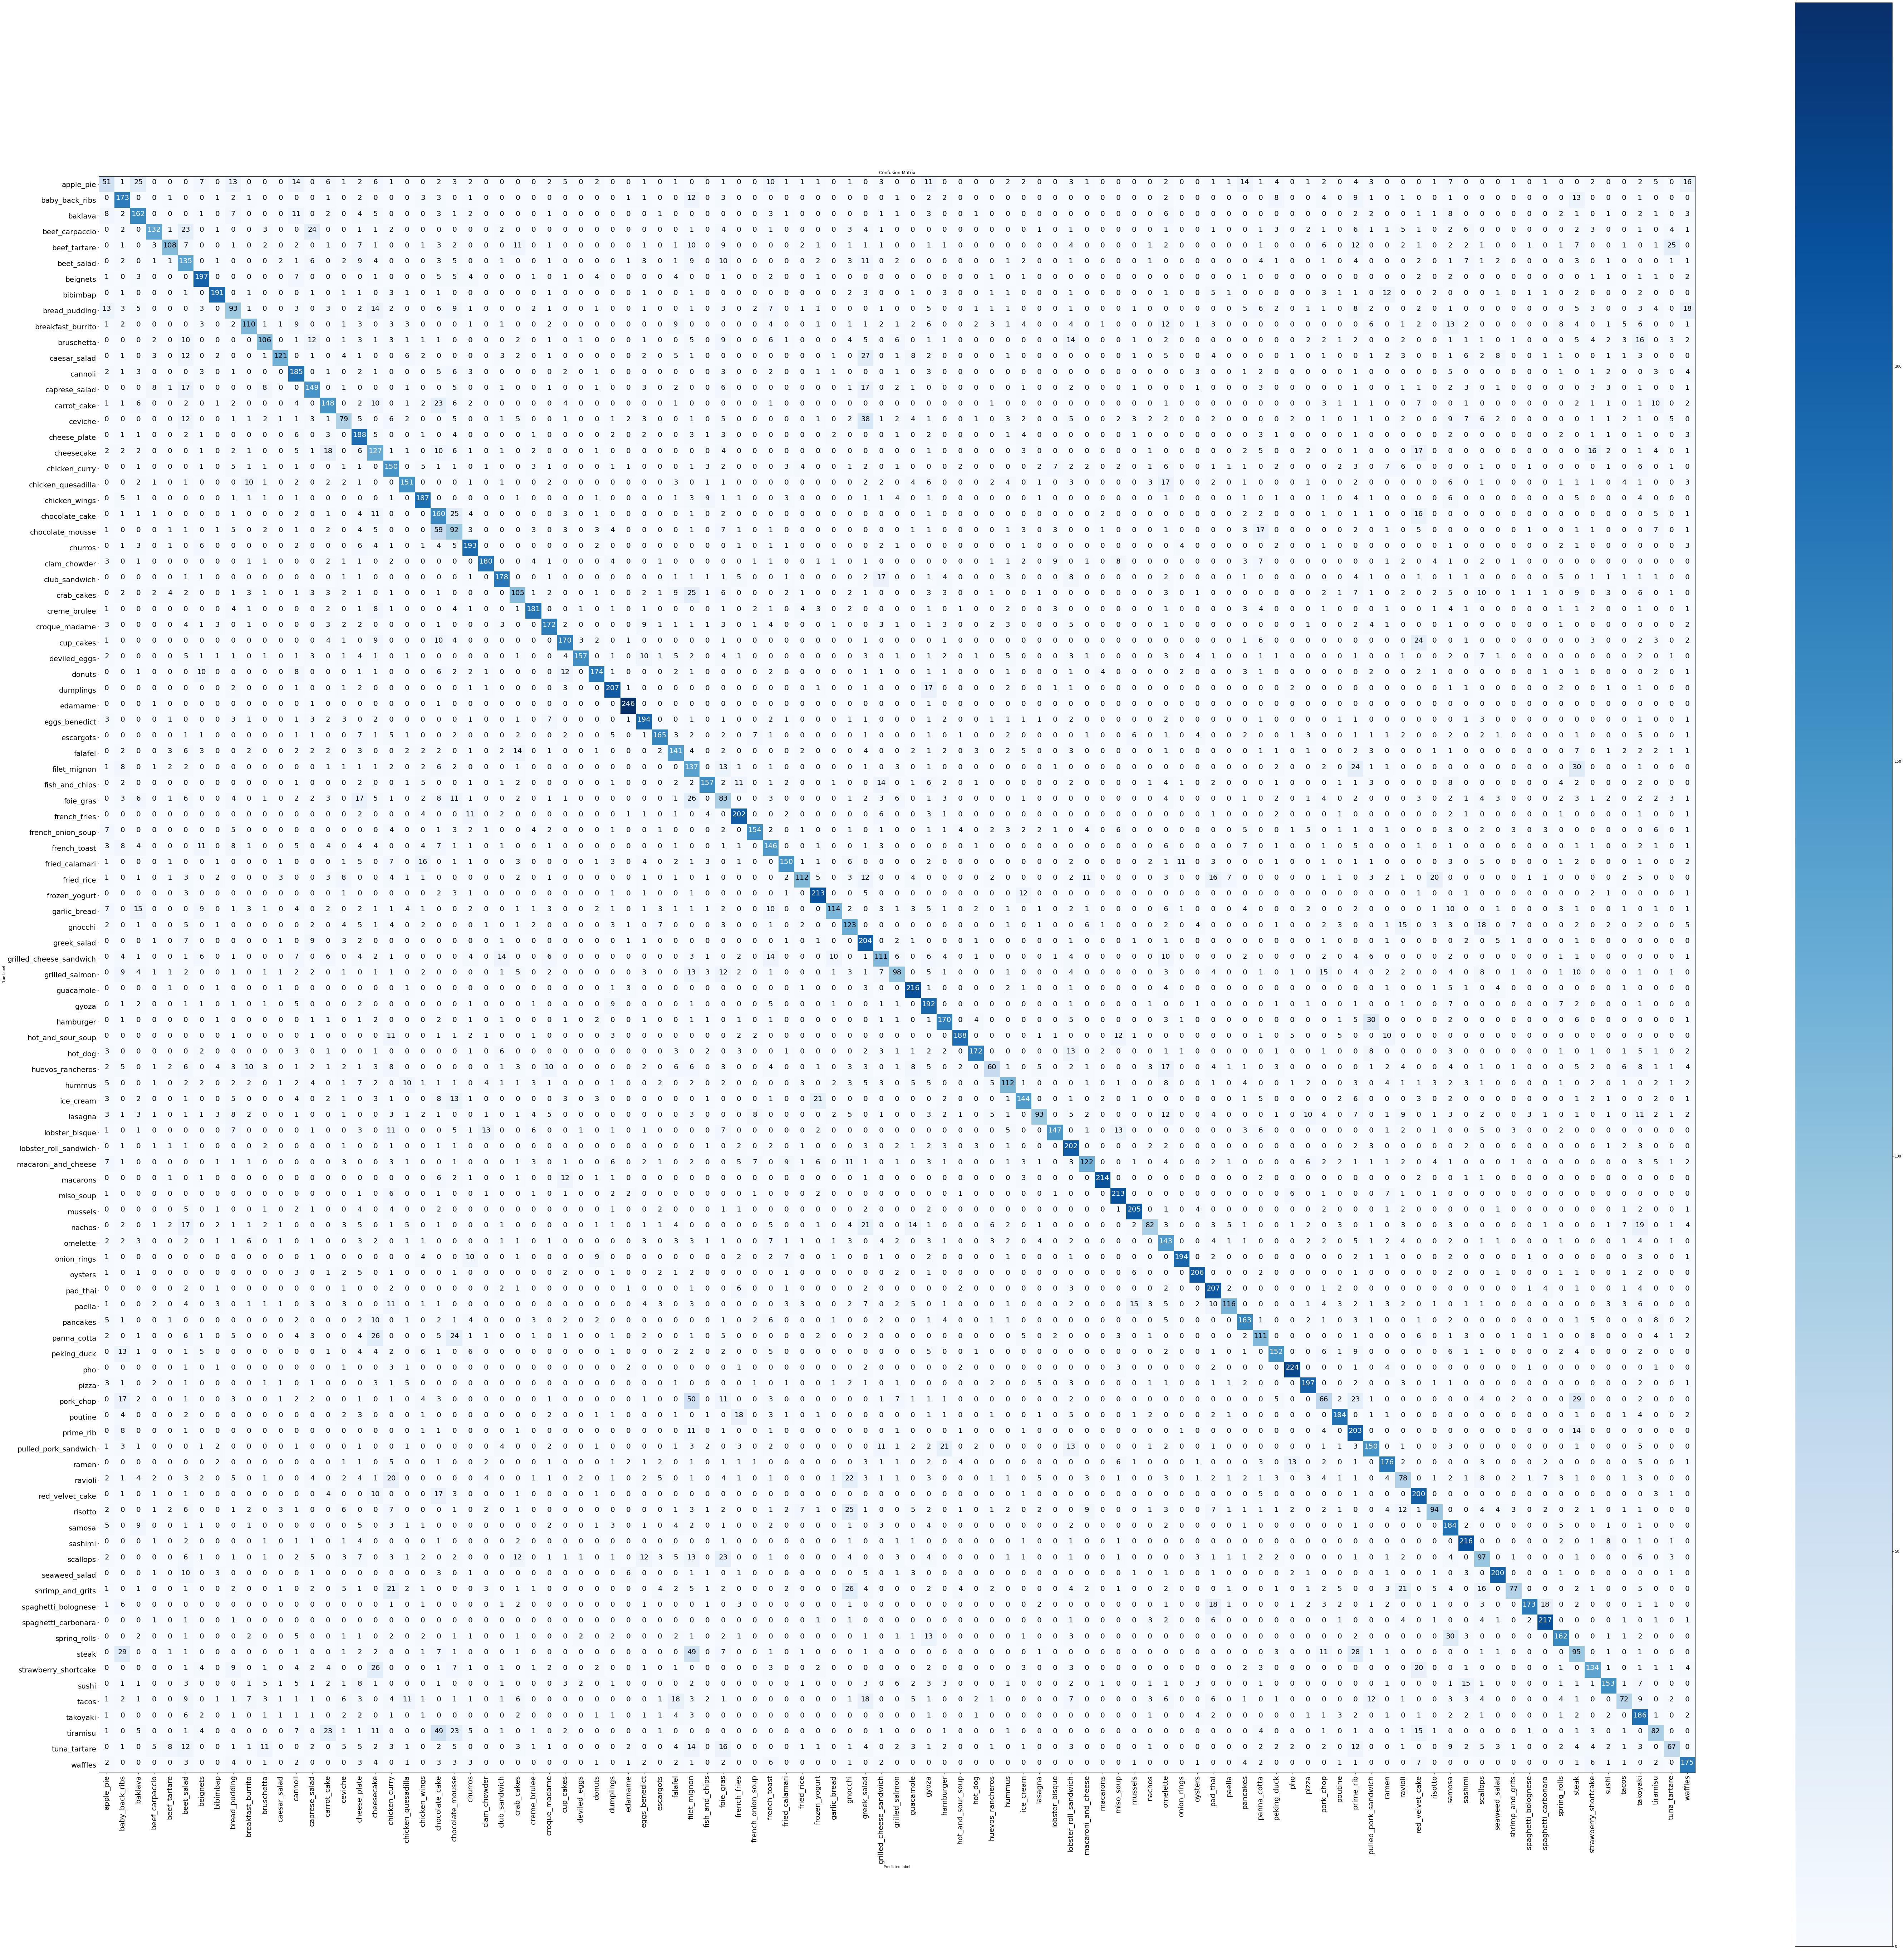

In [45]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has helpful function for aquiring many different classification metrics per class (e.g. precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.52       250
          10       0.62      0.42      0.50       250
          11       0.83      0.48      0.61       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [47]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true=y_labels, y_pred=pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5605536332179931,
  'recall': 0.648,
  'f1-score': 0.601113172541744,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.3426395939086294,
  'recall': 0.54,
  'f1-score': 0.4192546583850932,
  'support': 250},
 '6': {'precision': 0.6700680272108843,
  'recall': 0.788,
  'f1-score': 0.724264705882353,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 2

Let's plot all of our classes F1-scores...

In [48]:
# Create empty dictionary
class_f1_scores = dict()

# Loop through classification report dictionary items:
for k, v in classification_report_dict.items():
    if k == "accuracy":  # stop once we get to accuracy key
        break
    else:
        # Add class names and F1-scores to new dictionary
        class_f1_scores[test_data.class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.601113172541744,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.4192546583850932,
 'beignets': 0.724264705882353,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5152224824355972,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6126582278481012,
 'cannoli': 0.6125827814569537,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.5736434108527131,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.4261744966442953,
 'chicken_curry': 0.5025125628140704,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45325779036827196,
 'chocolate_mousse': 0.32857142857142857,
 'churros': 0.7148148148148148,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.7325102880658436,
 'crab_cakes': 0.46153846153846156,
 'creme_brulee

In [49]:
# Turn F1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "F1-score": list(class_f1_scores.values())}).sort_values("F1-score", ascending=False)
f1_scores

class_names  F1-score
33              edamame  0.935361
63             macarons  0.895397
75                  pho  0.869903
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.336134
22     chocolate_mousse  0.328571
77            pork_chop  0.304850
39            foie_gras  0.296959
0             apple_pie  0.240566

[101 rows x 2 columns]

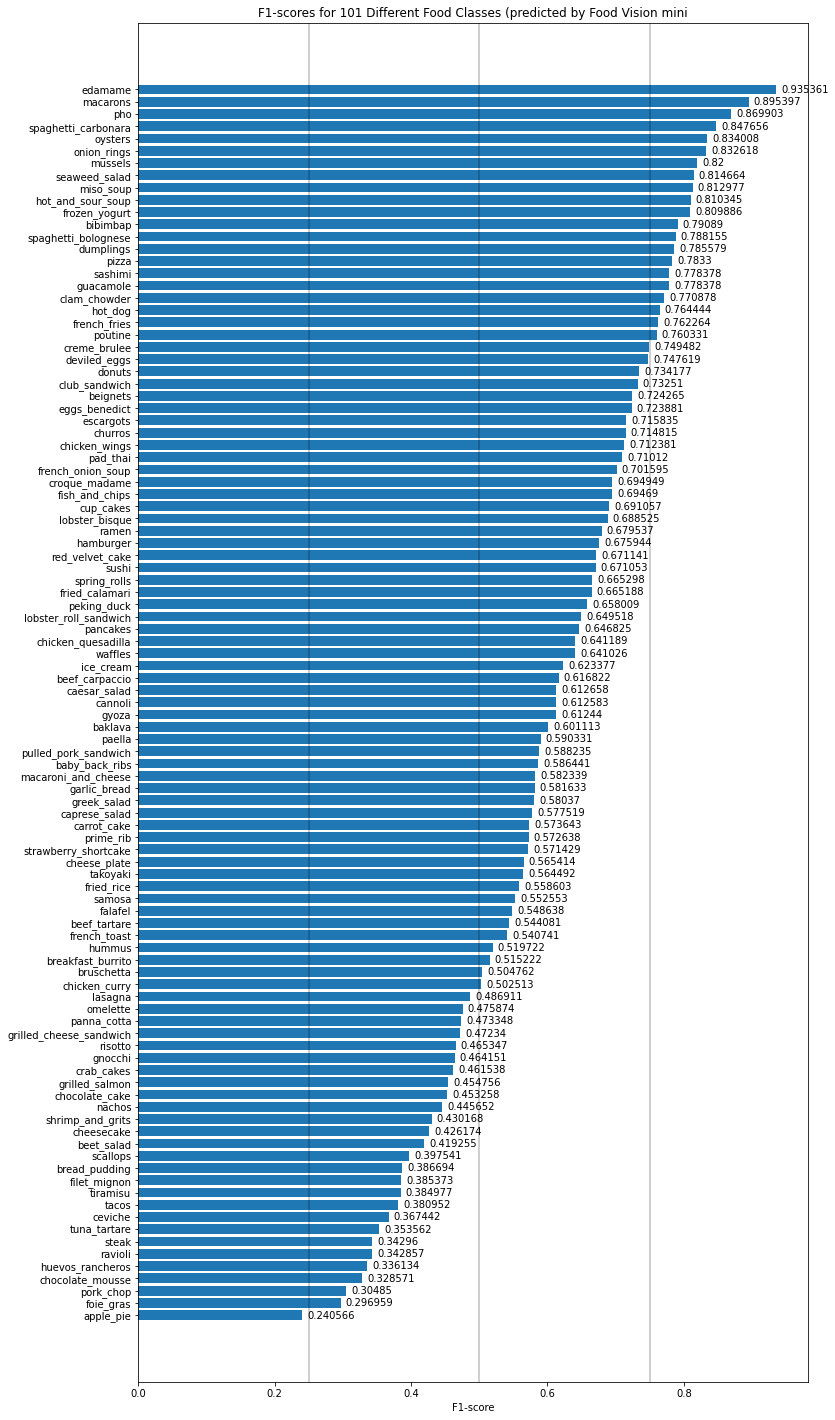

In [50]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["F1-score"].values)  # get F1-score values
ax.bar_label(scores, padding=5)
ax.axvline(0.25, color="black", alpha=0.25)
ax.axvline(0.5, color="black", alpha=0.25)
ax.axvline(0.75, color="black", alpha=0.25)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores.class_names)
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini")
ax.invert_yaxis()

# Challenge: add values to the end of each bar of what the actual F1-score is
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html)
# Note: not sure if bar_label wasn't available at the time the lecture was recorded, but that seemed easier to use


 🛠 **Exercise:** Try visualizing some of the most poorly predicted classes (e.g. `apple_pie`, `pork_chop`), do you notice any trends among them? Why might our model be having trouble with them?

## Visualizing predictions on test images

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using `tensorflow.io.read_file()`
* Turn the image into a tensor using `tensorflow.io.decode_image()`
* Resize the image tensor to be the same size as the images our model has trained on using `tensorflow.image.resize()`
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [51]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    specified shape (img_shap, img_shape, color_channels=3).

    Args:
        filename (str): path to target image
        img_shape (int): height/width dimension of target image size
        scale (bool): scale pixel values from 0-255 to 0-1 or not

    Returns:
        Image tensor of shape (img_shape, img_shape, 3)
    """
    # Read in the image
    img = tf.io.read_file(filename)

    # Decode image into tensor
    img = tf.io.decode_image(img, channels=3)

    # Resize the image tensor
    img = tf.image.resize(img, [img_shape, img_shape])

    # Scale image if needed
    if scale:
        # Rescale the image (get all values between 0 and 1)
        return img/255.

    return img

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the models predictions, prediction probabilty and truth label


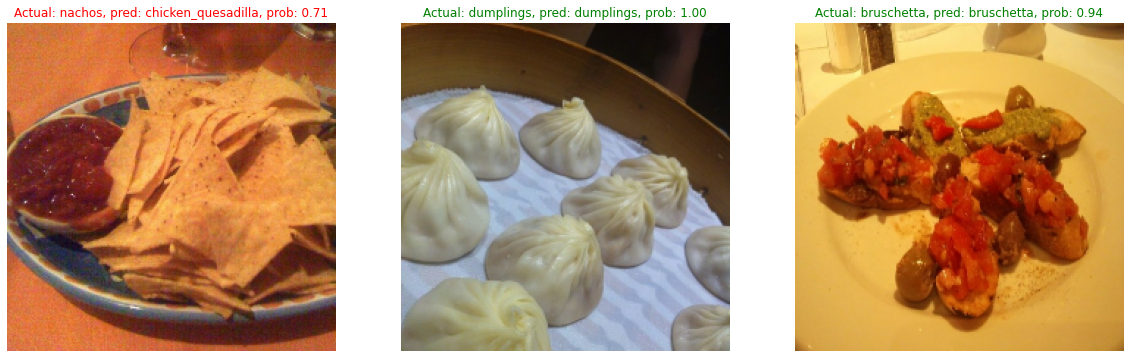

In [52]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(20, 10))

for i in range(3):
    # Choose random a image from a random class
    class_name = random.choice(test_data.class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename

    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    pred_prob = model.predict(img_expanded, verbose=0)  # get prediction probabilities array
    pred_class = test_data.class_names[pred_prob.argmax()]  # get highest prediction probability index

    # Plot the image
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class:  # if predicted class matches truth class, make text green
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False)


## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using [`list_files()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on the wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [53]:
# 1. Get all of the image file paths in the test dataset
filepaths = list()
for filepath in test_data.list_files("./101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
    filepaths.append(filepath.numpy())
filepaths[:10]

[b'.\\101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [54]:
# 2. Create a pandas DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1),  # get the maximum prediction probability value
                        "y_true_classname": [test_data.class_names[i] for i in y_labels],
                        "y_pred_classname": [test_data.class_names[i] for i in pred_classes]})
pred_df.head(10)

img_path  y_true  y_pred  \
0  b'.\\101_food_classes_10_percent\\test\\apple_...       0      52   
1  b'.\\101_food_classes_10_percent\\test\\apple_...       0       0   
2  b'.\\101_food_classes_10_percent\\test\\apple_...       0       0   
3  b'.\\101_food_classes_10_percent\\test\\apple_...       0      80   
4  b'.\\101_food_classes_10_percent\\test\\apple_...       0      79   
5  b'.\\101_food_classes_10_percent\\test\\apple_...       0      61   
6  b'.\\101_food_classes_10_percent\\test\\apple_...       0      29   
7  b'.\\101_food_classes_10_percent\\test\\apple_...       0       0   
8  b'.\\101_food_classes_10_percent\\test\\apple_...       0      85   
9  b'.\\101_food_classes_10_percent\\test\\apple_...       0       0   

   pred_conf y_true_classname       y_pred_classname  
0   0.847907        apple_pie                  gyoza  
1   0.963443        apple_pie              apple_pie  
2   0.959498        apple_pie              apple_pie  
3   0.656179        apple_pie   pulled_pork_sandwich  
4   0.364332        apple_pie              prime_rib  
5   0.455618        apple_pie  lobster_roll_sandwich  
6   0.611707        apple_pie              cup_cakes  
7   0.473575        apple_pie              apple_pie  
8   0.245616        apple_pie                 samosa  
9   0.724345        apple_pie              apple_pie

In [55]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df.y_true == pred_df.y_pred
pred_df.head(10)

img_path  y_true  y_pred  \
0  b'.\\101_food_classes_10_percent\\test\\apple_...       0      52   
1  b'.\\101_food_classes_10_percent\\test\\apple_...       0       0   
2  b'.\\101_food_classes_10_percent\\test\\apple_...       0       0   
3  b'.\\101_food_classes_10_percent\\test\\apple_...       0      80   
4  b'.\\101_food_classes_10_percent\\test\\apple_...       0      79   
5  b'.\\101_food_classes_10_percent\\test\\apple_...       0      61   
6  b'.\\101_food_classes_10_percent\\test\\apple_...       0      29   
7  b'.\\101_food_classes_10_percent\\test\\apple_...       0       0   
8  b'.\\101_food_classes_10_percent\\test\\apple_...       0      85   
9  b'.\\101_food_classes_10_percent\\test\\apple_...       0       0   

   pred_conf y_true_classname       y_pred_classname  pred_correct  
0   0.847907        apple_pie                  gyoza         False  
1   0.963443        apple_pie              apple_pie          True  
2   0.959498        apple_pie              apple_pie          True  
3   0.656179        apple_pie   pulled_pork_sandwich         False  
4   0.364332        apple_pie              prime_rib         False  
5   0.455618        apple_pie  lobster_roll_sandwich         False  
6   0.611707        apple_pie              cup_cakes         False  
7   0.473575        apple_pie              apple_pie          True  
8   0.245616        apple_pie                 samosa         False  
9   0.724345        apple_pie              apple_pie          True

In [56]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df.pred_correct == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'.\\101_food_classes_10_percent\\test\\scallo...      87      29   
231    b'.\\101_food_classes_10_percent\\test\\apple_...       0     100   
15359  b'.\\101_food_classes_10_percent\\test\\lobste...      61      53   
23539  b'.\\101_food_classes_10_percent\\test\\strawb...      94      83   
21400  b'.\\101_food_classes_10_percent\\test\\samosa...      85      92   
24540  b'.\\101_food_classes_10_percent\\test\\tirami...      98      83   
2511   b'.\\101_food_classes_10_percent\\test\\brusch...      10      61   
5574   b'.\\101_food_classes_10_percent\\test\\chocol...      22      21   
17855  b'.\\101_food_classes_10_percent\\test\\paella...      71      65   
23797  b'.\\101_food_classes_10_percent\\test\\sushi\...      95      86   
18001  b'.\\101_food_classes_10_percent\\test\\pancak...      72      67   
11642  b'.\\101_food_classes_10_percent\\test\\garlic...      46      10   
10847  b'.\\101_food_classes_10_percent\\test\\fried_...      43      68   
23631  b'.\\101_food_classes_10_percent\\test\\strawb...      94      83   
1155   b'.\\101_food_classes_10_percent\\test\\beef_t...       4       5   
10854  b'.\\101_food_classes_10_percent\\test\\fried_...      43      68   
23904  b'.\\101_food_classes_10_percent\\test\\sushi\...      95      86   
7316   b'.\\101_food_classes_10_percent\\test\\cup_ca...      29      83   
13144  b'.\\101_food_classes_10_percent\\test\\gyoza\...      52      92   
10880  b'.\\101_food_classes_10_percent\\test\\fried_...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999982                 samosa           spring_rolls         False  
24540   0.999946               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999930                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999902               pancakes               omelette         False  
11642   0.999879           garlic_bread             bruschetta         False  
10847   0.999870         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999857           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999797                  gyoza           spring_rolls         False  
10880   0.999779         fried_calamari            onion_rings         False

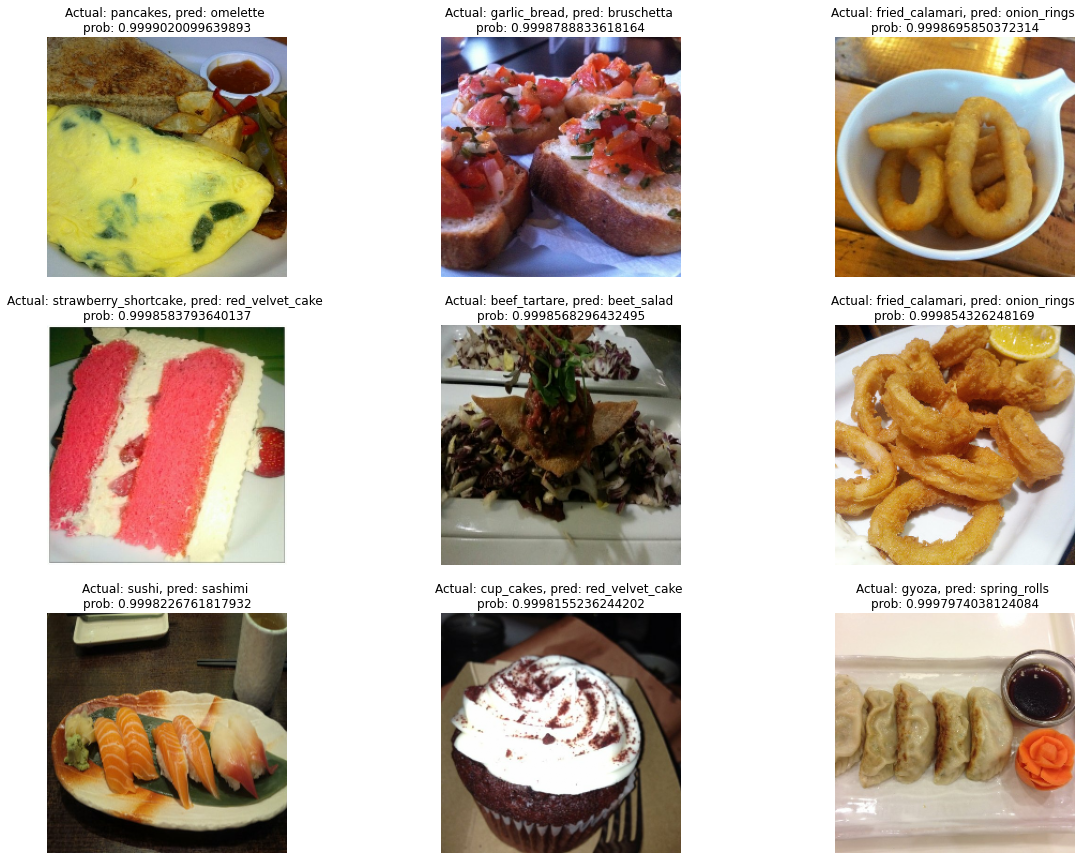

In [59]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 10
end_index = start_index + images_to_view
plt.figure(figsize=(20, 15))

for i, row in enumerate(top_100_wrong[start_index:end_index].itertuples()):
    # Load the image
    img = load_and_prep_image(row.img_path, scale=False)

    # Plot the image
    plt.subplot(3, 3, i+1)
    plt.imshow(img/255.)
    plt.title(f"Actual: {row.y_true_classname}, pred: {row.y_pred_classname} \nprob: {row.pred_conf}")
    plt.axis(False)

## Test out the big dog model on our own custom images

In [61]:
# Get custom images
# import wget
# wget.download("https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip")

# unzip_data("custom_food_images.zip")

In [62]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg']

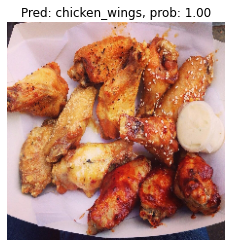

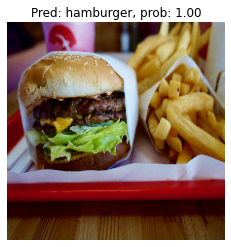

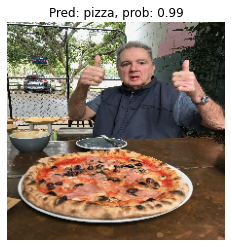

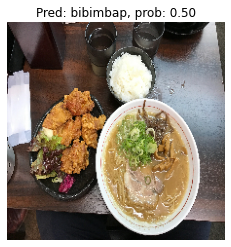

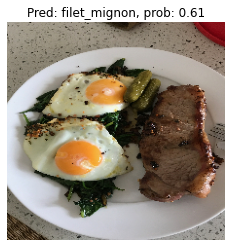

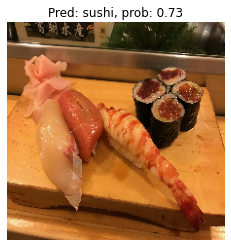

In [65]:
# Make predictions on and plot custom food images
for img in custom_food_images:
    img = load_and_prep_image(img, scale=False)  # don't need to scale for our EfficientNetB0 model
    pred_prob = model.predict(tf.expand_dims(img, axis=0), verbose=0)  # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
    pred_class = test_data.class_names[pred_prob.argmax()]  # get the index with the highest prediction probability
    # Plot the appropriate iformation
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"Pred: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis(False)

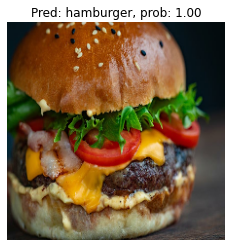

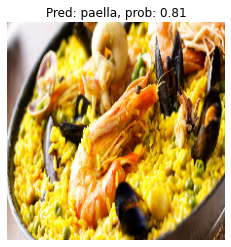

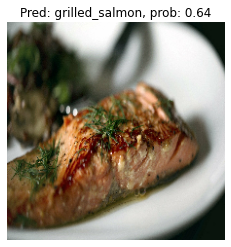

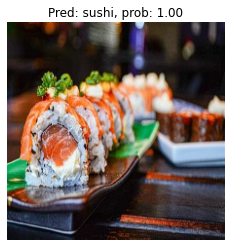

In [70]:
# Get the custom food images filepaths
custom_food_images = ["06_exercise_images/" + img_path for img_path in os.listdir("06_exercise_images")]

# Make predictions on and plot custom food images
for img in custom_food_images:
    img = load_and_prep_image(img, scale=False)  # don't need to scale for our EfficientNetB0 model
    pred_prob = model.predict(tf.expand_dims(img, axis=0), verbose=0)  # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
    pred_class = test_data.class_names[pred_prob.argmax()]  # get the index with the highest prediction probability
    # Plot the appropriate iformation
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"Pred: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis(False)